<a href="https://colab.research.google.com/github/reyna168/Data-Analysis/blob/master/FinLab_Python_%E6%96%B0%E6%89%8B%E6%95%99%E5%AD%B8_part7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import json
import requests
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def crawl_price(stock_id):

    d = datetime.datetime.now()
    url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2="+str(int(d.timestamp()))+"&interval=1d&events=history&=hP2rOschxO0"

    res = requests.get(url)
    data = json.loads(res.text)
    df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
    return df



twii = crawl_price("^TWII")
twii.head()

,open,close,volume,high,low
1997-07-02 01:00:00,9094.269531,8996.719727,0.0,9124.299805,8988.129883
1997-07-03 01:00:00,9061.599609,9027.629883,0.0,9061.599609,8997.509766
1997-07-04 01:00:00,9144.959961,9192.570312,0.0,9218.209961,9119.250000
1997-07-07 01:00:00,9365.190430,9322.839844,0.0,9370.410156,9304.820312
1997-07-08 01:00:00,9345.549805,9305.269531,0.0,9371.500000,9282.099609


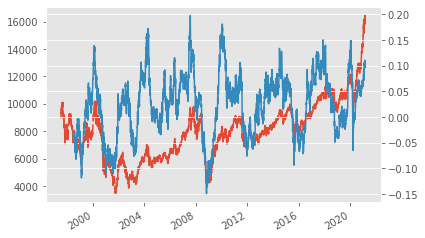

In [2]:
mean = twii['close'].pct_change().rolling(252).mean()
std = twii['close'].pct_change().rolling(252).std()

sharpe = mean / std

twii.close.plot()
sharpe.plot(secondary_y=True)

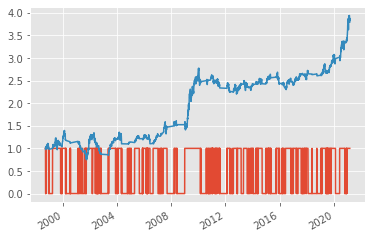

In [3]:
import numpy as np

# sharpe ratio 平滑
sr = sharpe
srsma = sr.rolling(60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.plot()

# 持有時候的績效
adj = twii['close'][buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()

In [5]:
def backtest(a, b, c, d, plot=False):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    
    adj = twii['close'][buy.index]

    if plot:
        (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
        hold.plot()

    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1


backtest(252,0.4,0.6,4)

1.3672665689830454

In [6]:
maxeq = 0

for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10):
                
                eq = backtest(a,b,c,d)
                
                if maxeq < eq:
                    maxeq = eq
                    print(eq, a,b,c,d)

1.848192349811713 100 0.3 0.3 60
1.9669443529224526 100 0.3 0.3 70
2.591734105839739 100 0.3 0.3 160
2.6104878298184007 100 0.3 0.3899999999999999 160
2.6583845506584294 100 0.3 0.4199999999999999 160
3.1065229091510322 100 0.3 0.44999999999999984 160
3.9162204475336795 100 0.3 0.5399999999999998 160
4.0030141262722045 100 0.32999999999999996 0.5399999999999998 160
4.117234477291332 100 0.35999999999999993 0.5399999999999998 160
4.366910550791006 100 0.6599999999999997 0.35999999999999993 150
4.527301490207772 100 0.6599999999999997 0.3899999999999999 150
5.450985944079535 100 0.6599999999999997 0.4199999999999999 150
5.523736469607194 100 0.6899999999999996 0.44999999999999984 150


3.773909089092512

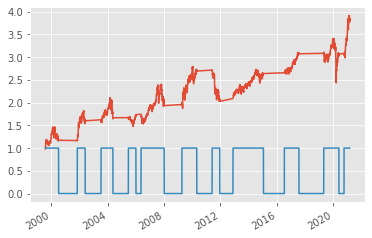

In [7]:
backtest(120, 0.78, 0.39, 140, plot=True)